In [55]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pandas_ta as ta
import math

In [56]:
aapl = pd.read_csv('AAPL_1min.csv')
cbh = pd.read_csv('cbh_1min.csv')
acv = pd.read_csv('ACV_1min.csv')
amzn = pd.read_csv('AMZN_1min.csv')

stock_str = ['AAPL', 'CBH', 'ACV', 'AMZN']

In [57]:
selected_stock = [aapl, cbh, acv, amzn]    # making a list of stocks 

aapl_hf = pd.DataFrame()   # definig a data frame
cbh_hf = pd.DataFrame()    # definig a data frame
acv_hf = pd.DataFrame()    # definig a data frame
amzn_hf = pd.DataFrame()    # definig a data frame

high_freq_stock = [aapl_hf, cbh_hf, acv_hf, amzn_hf]   # making a list of stocks for high frequency trading

#defining start time and end time and start date
start_time = pd.to_datetime('09:29:00').time()
end_time = pd.to_datetime('16:00:00').time()
start_date = pd.to_datetime('2022').date()

# finding minute by minute data and daily data
for i, stock in enumerate(selected_stock):      
    selected_stock[i].columns = ['Timestamp','open','high','low','close','volume']   # adding column title to the data frame
    selected_stock[i]['Timestamp'] = pd.to_datetime(selected_stock[i]['Timestamp'])   # converting character string to date-time
    end_date = max(stock['Timestamp'].dt.date)
    selected_stock[i] = selected_stock[i][(selected_stock[i]['Timestamp'].dt.time == end_time)]    # closing price of stock 

    # getting minute by minute data between 9:30 a.m and 4:00 p.m.
    high_freq_stock[i] = stock[(stock['Timestamp'].dt.date >= start_date) & 
                               (stock['Timestamp'].dt.time >= start_time) & 
                               (stock['Timestamp'].dt.time <= end_time)]
    high_freq_stock[i].reset_index(drop=True, inplace=True)   # reindexing

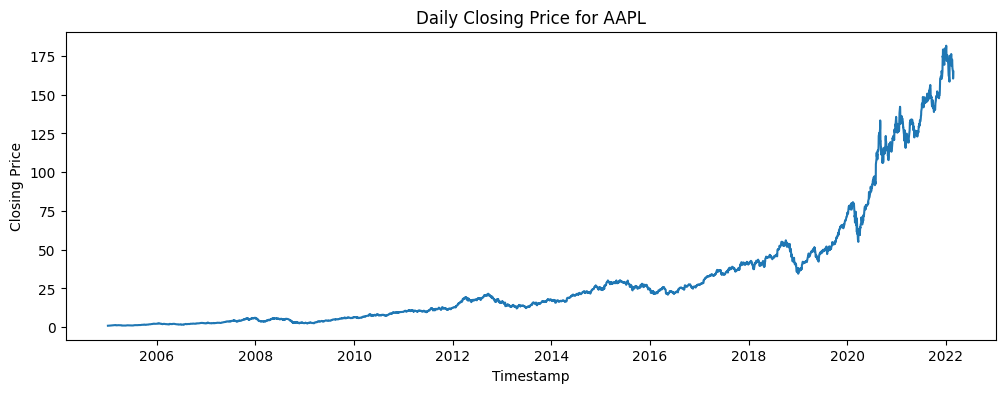

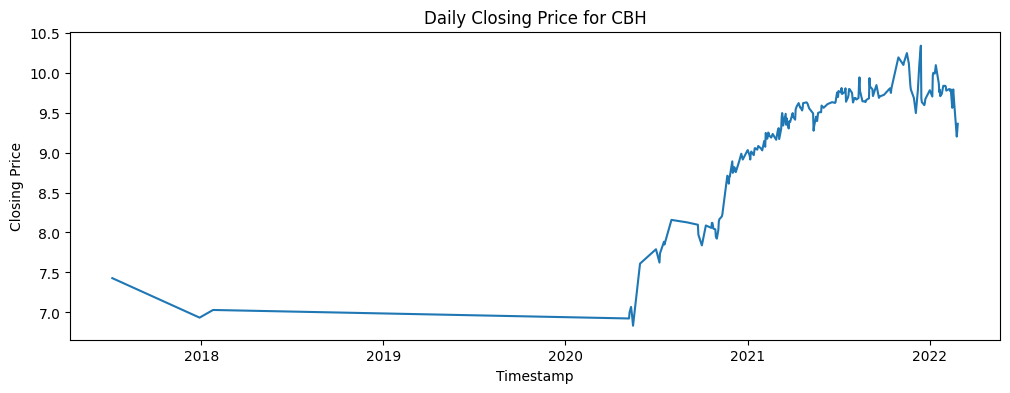

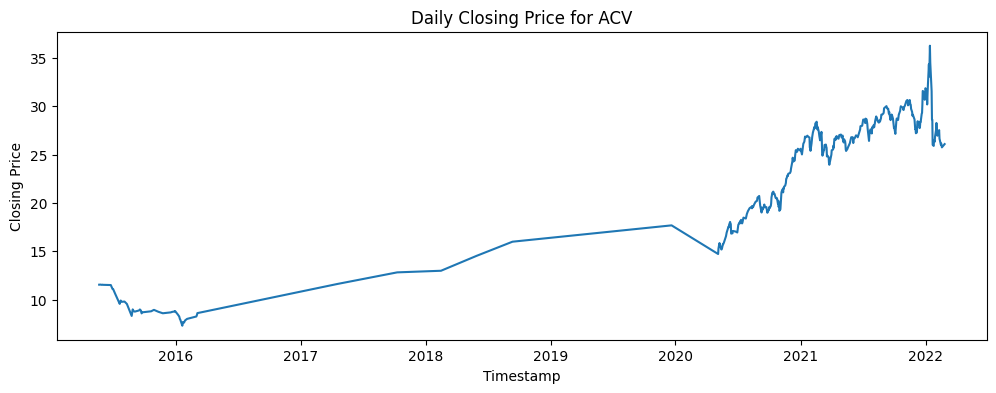

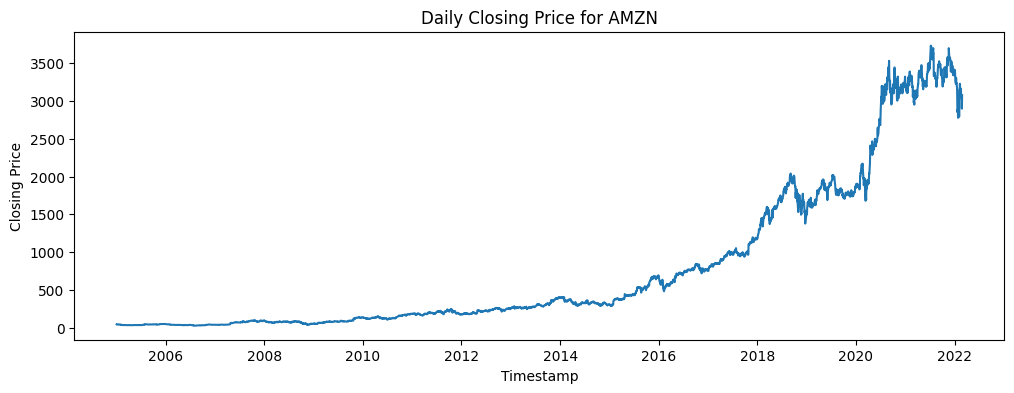

In [58]:
''' Plot daily closing price for a few stocks '''

for i, stock in enumerate (selected_stock):
    plt.figure(figsize=(12, 4))
    plt.plot(stock['Timestamp'], stock['close'], label=stock)
    plt.xlabel('Timestamp')
    plt.ylabel('Closing Price')
    plt.title('Daily Closing Price for '+stock_str[i])
    plt.show()

In [59]:
'''Ploting candlestick chart for the last available date'''  

import plotly.graph_objects as go

# Loop through the selected stocks and add traces to the figure
for i, stock in enumerate(high_freq_stock):
    # slicing out the last available date
    end_date = max(stock['Timestamp'].dt.date)
    stock = stock[(stock['Timestamp'].dt.date == end_date)]
    
    fig = go.Figure()
    # Add a candlestick trace
    fig.add_trace(go.Candlestick(x=stock['Timestamp'],
                    open=stock['open'],
                    high=stock['high'],
                    low=stock['low'],
                    close=stock['close'],
                    name=f'Stock {i+1}'))

    # Add a volume bar chart on a secondary y-axis
    fig.add_trace(go.Bar(x=stock['Timestamp'],
                y=stock['volume'],
                yaxis='y2',
                name=f'Volume {i+1}'))

    # Customize the layout
    fig.update_layout(title='Candlestick Chart with Volume of '+stock_str[i],
                      xaxis_title='Time',
                      yaxis_title='Price',
                      xaxis_rangeslider_visible=True,
                      yaxis2=dict(title='Volume', overlaying='y', side='right'))

    # Show the chart
    fig.show()

clearly since only AAPL has considerably less missing values, it ecomes an obvious choce for training the model and subssequently testing. Later we can test it on various other stocks for high frequency intraday trading. 

### Filling timestamps and missing values
Since minute by minute data does not have much variance hence it is reasonable to linearly interpolate the previous available data. This method is only going to work if the missing values are very less and considerably spaced apart. We will also have to consider holidays when market is closed.

In [60]:
import pandas as pd

def fill_missing(data_frame):      # making a function to fill the missing timestamps and fill it 
    expected_timestamps = pd.date_range(start=data_frame['Timestamp'].min().replace(hour=start_time.hour, minute=start_time.minute),
                                       end=data_frame['Timestamp'].max().replace(hour=end_time.hour, minute=end_time.minute),
                                       freq='T')
    expected_dates = data_frame['Timestamp'].dt.date.drop_duplicates()  # we do not want to interpolate values on holidays
    
    data_frame.set_index('Timestamp', inplace=True) # resetting the index
    data_frame = data_frame.reindex(expected_timestamps)
    
    # Interpolate and fill missing data with the previous available value (forward fill)
    data_frame.interpolate(method='time', inplace=True)  # Use 'time' method for datetime index
    
    data_frame.reset_index(inplace=True)  # reindexing
    
    data_frame = data_frame[(data_frame['index'].dt.time >= start_time) &   # filterind data by start time
                            (data_frame['index'].dt.time <= end_time) &     # filterind data by end time
                            (data_frame['index'].dt.date.isin(expected_dates))]    # filterind data by holidays
    
    data_frame.reset_index(drop=True, inplace=True)  # Reindex the DataFrame
    return data_frame

aapl_hf = fill_missing(high_freq_stock[0])
amzn_hf = fill_missing(high_freq_stock[3])
print(aapl_hf.info())
print(amzn_hf.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14896 entries, 0 to 14895
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   14896 non-null  datetime64[ns]
 1   open    14896 non-null  float64       
 2   high    14896 non-null  float64       
 3   low     14896 non-null  float64       
 4   close   14896 non-null  float64       
 5   volume  14896 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 698.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14896 entries, 0 to 14895
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   14896 non-null  datetime64[ns]
 1   open    14896 non-null  float64       
 2   high    14896 non-null  float64       
 3   low     14896 non-null  float64       
 4   close   14896 non-null  float64       
 5   volume  14896 non-null  float64       
dtypes: dateti

### Normalization

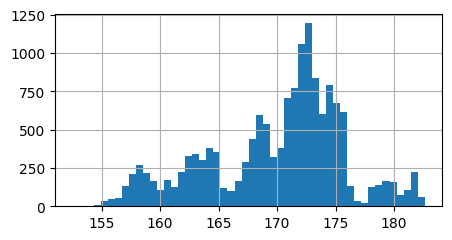

In [61]:
aapl_hf1 = aapl_hf.drop('index', axis = 1, inplace = False)  # dropping the timstamp because it's not needed for normalization
aapl_hf1['open'].hist(bins=50, figsize=(5,2.5))   # visualizing only open prices as of now
plt.show()

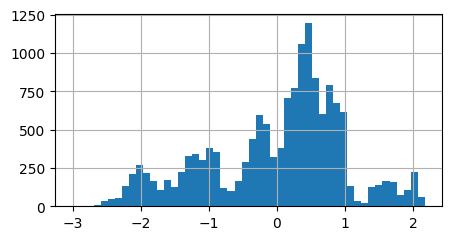

In [62]:
'''Normalization'''

from sklearn.preprocessing import StandardScaler
scaler_std = StandardScaler()
scaled_data_standard = scaler_std.fit_transform(aapl_hf1)
scaled_data_standard = pd.DataFrame(scaled_data_standard)
scaled_data_standard[0].hist(bins=50, figsize=(5,2.5))   # visualizing only open prices as of now
plt.show()

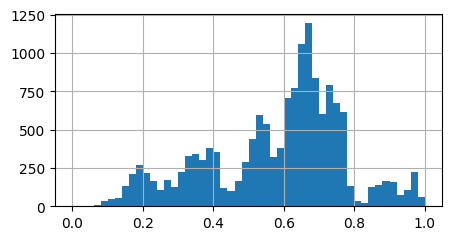

In [63]:
# min max normalization
from sklearn.preprocessing import MinMaxScaler
scaler_min_max = MinMaxScaler(feature_range=(0,1))
scaled_data_min_max = scaler_min_max.fit_transform(aapl_hf1)
scaled_data_min_max = pd.DataFrame(scaled_data_min_max)
scaled_data_min_max[0].hist(bins=50, figsize=(5,2.5))   # visualizing only open prices as of now
plt.show()

In [64]:
# since min max scaling brings the data in the range of [0,1], rather than negative range as sin standard scaler.
# we don't want negative numbers hence we choose min max scaler over standard scaler

## Implemeting LSTM using Pytorch.
### Structure:
1. importing PyTorch and designing the model 
2. initializing hyperparameters
3. defining data loader
4. Loss optimization
5. Training

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class My_LSTM_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(My_LSTM_Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM model 
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) 

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
    
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :]) 
        #out = torch.sigmoid(out)
        return out

In [81]:
# Hyperparameter initialization
input_dim = 5
hidden_dim = 20
num_layers = 2 
output_dim = 1
batch_size = 64
learning_rate = 0.03

look_back = 5
percentage_train_split = 0.8

In [82]:
def data_loader(stock, look_back, percentage_train_split): 
    '''input: stock(DataFrame), look_back(number of data points to look back to predict the next one)
              percentage_split(split percentage), batch_size(to divide into batch)
       output: [x_train, y_train, x_test, y_test] all tensor'''
    data_frame = stock.values 
    df = [] 
    
    for i in range(stock.shape[0]-look_back):
        df.append(data_frame[i:look_back+i,:])
        
    df = np.array(df)
    test_set_size = int((1-percentage_train_split)*df.shape[0])
    train_set_size = df.shape[0] - (test_set_size)
    
    # splitting the data
    x_train = df[:train_set_size, :-1, :]     # extracting trainning set
    y_train = df[:train_set_size, -1, 3]
    
    x_test = df[train_set_size:, :-1, :]     # extracting testing set
    y_test = df[train_set_size:, -1, 3]
    
    # converting all to tensor to feed the LSTM network    
    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    
    y_train = torch.from_numpy(y_train).type(torch.Tensor).reshape(-1,1)   # reshaping to make it a column vector
    y_test = torch.from_numpy(y_test).type(torch.Tensor).reshape(-1,1)     # reshaping to make it a column vector
    
    print('x_train shape: ', x_train.shape)   # printing the dimensions of the tensors
    print('y_train shape: ', y_train.shape)
    print('x_test shape: ', x_test.shape )
    print('y_test shape: ', y_test.shape )    
    
    # f"Initial Balance: ${first_investment:.2f}
    
    return [x_train, y_train, x_test, y_test]

x_train, y_train, x_test, y_test = data_loader(scaled_data_min_max, look_back, percentage_train_split)


x_train shape:  torch.Size([11913, 4, 5])
y_train shape:  torch.Size([11913, 1])
x_test shape:  torch.Size([2978, 4, 5])
y_test shape:  torch.Size([2978, 1])


In [83]:
# printing a few values of x_test and y_test for analysis
print('x_test:')
print(x_test[:2,:,:])
print()
print('y_test:')
print(y_test[:5])

x_test:
tensor([[[0.6343, 0.6316, 0.6416, 0.6337, 0.0060],
         [0.6343, 0.6306, 0.6380, 0.6297, 0.0050],
         [0.6305, 0.6270, 0.6351, 0.6290, 0.0065],
         [0.6300, 0.6277, 0.6334, 0.6257, 0.0080]],

        [[0.6343, 0.6306, 0.6380, 0.6297, 0.0050],
         [0.6305, 0.6270, 0.6351, 0.6290, 0.0065],
         [0.6300, 0.6277, 0.6334, 0.6257, 0.0080],
         [0.6262, 0.6227, 0.6328, 0.6254, 0.0052]]])

y_test:
tensor([[0.6254],
        [0.6247],
        [0.6236],
        [0.6225],
        [0.6214]])


In [84]:
import torch.optim as optim

model = My_LSTM_Model(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)

loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  
for t in range(num_epochs):
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    
    if (t+1) % 10 == 0 and t !=0:
        print("Epoch ", t+1, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.02870902605354786
Epoch  20 MSE:  0.03130972012877464
Epoch  30 MSE:  0.010929207317531109
Epoch  40 MSE:  0.0049826595932245255
Epoch  50 MSE:  0.0010289869969710708
Epoch  60 MSE:  0.000460023496998474
Epoch  70 MSE:  0.00040965768857859075
Epoch  80 MSE:  0.0002843030961230397
Epoch  90 MSE:  0.00021995157294441015
Epoch  100 MSE:  0.0001903893135022372


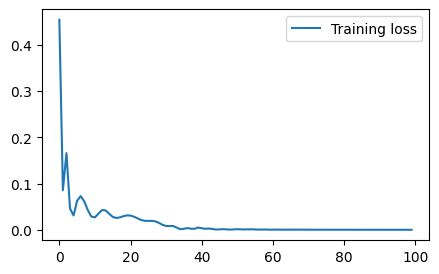

In [85]:
plt.figure(figsize=(5,3))
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

### Prediction and MSE calculation

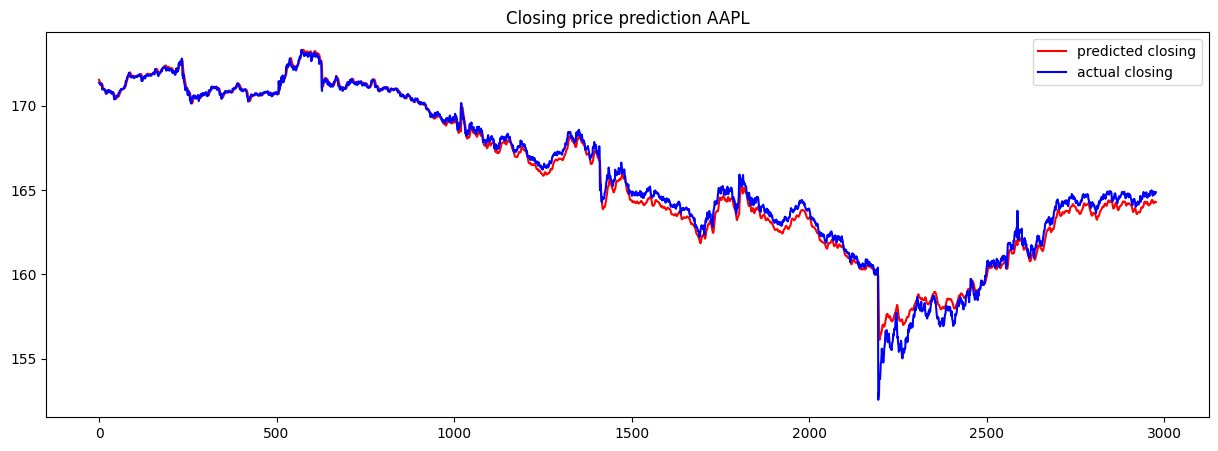

Test Score: 0.26 RMSE


In [87]:
def unscale_predictions(y_label, index):
    # invert predictions
    y_label_np = y_label.detach().numpy().reshape(-1)
    dummy_pred_array = np.zeros([y_label.shape[0],5])
    dummy_pred_array[:,index] = y_label_np
    y_pred = scaler_min_max.inverse_transform(dummy_pred_array)
    return y_pred

y_test_pred = model(x_test)

close_pred = unscale_predictions(y_test_pred,3)[:,3]
close_actual = unscale_predictions(y_test,3)[:,3]
plt.figure(figsize=(15,5))
plt.plot(close_pred, color = 'red', label ='predicted closing')
plt.plot(close_actual, color = 'blue', label ='actual closing')
plt.title('Closing price prediction AAPL')
plt.legend()
plt.show()

# calculate root mean squared error 
testScore = np.mean(np.square(close_pred - close_actual))
print('Test Score: %.2f RMSE' % (testScore))

## Inference
1. The model seems to do well on Timestamps very close to where training ended. 
2. Model is not able to handle sudden jumps or dips very well. It is able to handle jums when look_bak is high (like 15) i.e. to    predict next minute's closing we are lookin at last 14 Timestamps.
3. The model diverges vey fast when look_back value is low, where as reamins pretty consistent when value is set high
4. If look_back valu eis set high then it captures the trend very well but shifts the prediction graph towards right i.e. makes    delayed predictions which again makes the RMSE high

## Trading Simulation
Here, I'm attempting to simulate intraday trading, where I make a decision every minute, choosing to buy, hold, or sell. This simulation is conducted for a single day, but it can be adjusted to explore various other simulations, lasting up to one week. To keep things straightforward, I'm focusing on a single stock for buying and selling.

My trading strategy revolves around purchasing when the price is low and selling when it's high. Essentially, I observe the current closing price at time 't0' and attempt to predict the closing price at 't0+1' to base my decision on this prediction. The first plot illustrates the simulation using predicted values, while the second plot demonstrates what would occur if decisions were based on these predictions. Consequently, I aim to calculate the Return on Investment (ROI) and profit using actual values.
    

In [88]:
# Function to implement the trading strategy
def implement_strategy(data_frame, date, close_pred):
    # adding colummn 'close_pred' in the same data_frame
    data_frame['close_pred'] = np.nan    
    data_frame['close_pred'][data_frame.shape[0]-close_pred.shape[0]:] = close_pred

    # Extract data points for the given date
    selected_data = data_frame[data_frame['index'].dt.date == date]

    # Determine whether to buy, sell, or hold based on prediction
    # Buy if predicted price is higher than the current price, sell if lower, hold otherwise
    action = 'x'
    profit_actual = 0    # initialization of actual profit calculation
    prev_price = 0
    first_investment = 0
    
    profit_pred = 0     # initialization of actual profit calculation
    first_investment_pred = 0
    prev_price_pred = 0
    
    buy_signals = np.nan * np.zeros(selected_data.shape[0])    # initilization for plotting graph
    sell_signals = np.nan * np.zeros(selected_data.shape[0])
    buy_signals_actual = np.nan * np.zeros(selected_data.shape[0])
    sell_signals_actual = np.nan * np.zeros(selected_data.shape[0])

    selected_data = selected_data.reset_index()

    for i in range (2,selected_data.shape[0]):
        current_price = selected_data['close_pred'][i-1]
        predicted_closing = selected_data['close_pred'][i]

        if (predicted_closing > current_price and selected_data['close_pred'][i-2]> current_price):   # buy in dips
            action = 'Buy'
            buy_signals[i] = current_price    # updating signals which will be used to plot graph
            buy_signals_actual[i] = selected_data['close'][i]    # updating signals which will be used to plot graph
            
            prev_price = selected_data['close'][i]    # upating prev price for profit calculation
            prev_price_pred = selected_data['close_pred'][i]
            
            if first_investment == 0:
                first_investment = selected_data['close'][i]
                first_investment_pred = selected_data['close_pred'][i]
        elif (predicted_closing< current_price and current_price > selected_data['close_pred'][i-2] and action !='x'): # sell on highs
            action = 'Sell'
            sell_signals[i] = current_price   # updating signals which will be used to plot graph
            sell_signals_actual[i] = selected_data['close'][i]    # updating signals which will be used to plot graph
            profit_actual = profit_actual + selected_data['close'][i] - prev_price
            profit_pred = profit_pred + selected_data['close_pred'][i] - prev_price

        elif (predicted_closing < current_price and action == 'Sell'):  # nothing
            # even though teh action is set to SELL, but the teh actual action taken is none. It is just so that in the
            # next iteration it again satifies the above esle if conition
            action = 'Sell'

        elif(selected_data['index'].dt.time[i] == pd.to_datetime('16:00:00') and (action == 'Buy' or action == 'Hold')):  # Sell
            action = 'Sell'
            sell_signals[i] = current_price   # updating signals which will be used to plot graph
            sell_signals_actual[i] = selected_data['close'][i]   # updating signals which will be used to plot graph
            profit_actual = profit_actual + selected_data['close'][i] - prev_price
            profit_pred = profit_pred + selected_data['close_pred'][i] - prev_price

        else:    # Hold
            action = 'Hold'

    roi = profit_actual*100/first_investment  # roi formula

    # Plotting actual closing price, predicted closing price, and buy/sell signals
    plt.figure(figsize=(12, 5))
    plt.plot(selected_data.index, selected_data['close'], label='Actual Close',)
    plt.plot(selected_data.index, selected_data['close_pred'], label='Predicted Close', linestyle='--')
    plt.scatter(selected_data.index, buy_signals, marker='^', color='green', label='Buy Signal', s=20)
    plt.scatter(selected_data.index, sell_signals, marker='v', color='red', label='Sell Signal', s=20)
    plt.xlabel('Timestamp')
    plt.ylabel('Closing Price')
    plt.title('Trading Simulation on predicted closing price')
    plt.legend()
    plt.show()
    
    # printing predicted final returns 
    print(f"Initial Balance Predicted: ${first_investment_pred:.2f}")
    print(f"Final Balance Predicted: ${profit_pred+first_investment_pred:.2f}")
    print(f"Final Profit Predicted: ${profit_pred:.2f}")
    print(f"Returns Predicted: {profit_pred*100/first_investment_pred:.2f}%")
    print()
    
    
    # Plotting actual closing price, predicted closing price, and buy/sell signals    
    plt.figure(figsize=(12, 5))
    plt.plot(selected_data.index, selected_data['close'], label='Actual Close',)
    plt.scatter(selected_data.index, buy_signals_actual, marker='^', color='green', label='Buy Signal', s=20)
    plt.scatter(selected_data.index, sell_signals_actual, marker='v', color='red', label='Sell Signal', s=20)
    plt.xlabel('Timestamp')
    plt.ylabel('Closing Price')
    plt.title('Trading Simulation on actual closing price when ordrers are made based on predicted price')
    plt.legend()
    plt.show()
    
    # Print actual final returns
    print(f"Initial Balance: ${first_investment:.2f}")
    print(f"Final Balance: ${profit_actual+first_investment:.2f}")
    print(f"Final Profit: ${profit_actual:.2f}")
    print(f"Returns: {roi:.2f}%")
    print()


C:\Users\Suditi\AppData\Local\Temp\ipykernel_27676\250617755.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



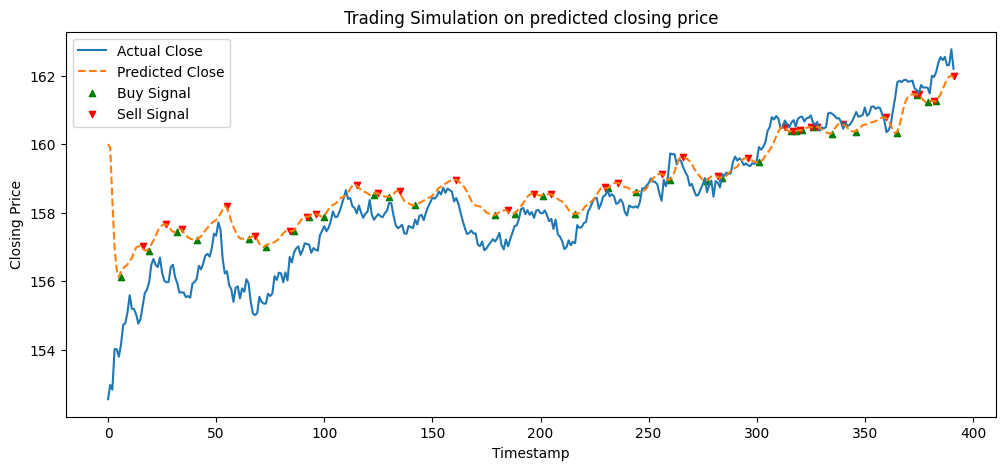

Initial Balance Predicted: $156.29
Final Balance Predicted: $177.34
Final Profit Predicted: $21.04
Returns Predicted: 13.46%



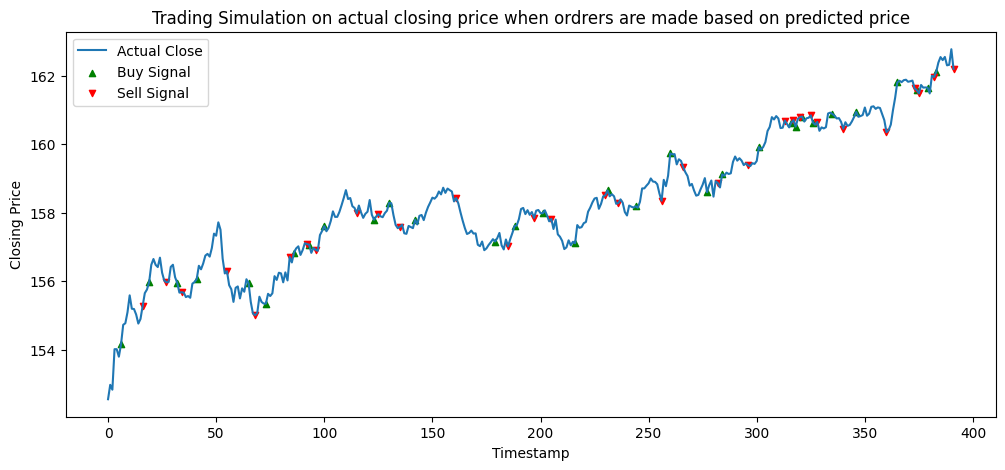

Initial Balance: $154.16
Final Balance: $157.76
Final Profit: $3.60
Returns: 2.34%



In [89]:
data_frame = aapl_hf
date = data_frame['index'].max().date() - pd.Timedelta(days=1)   # change days to see different day's simulation from 0 to 6
implement_strategy(data_frame, date, close_pred)

## Infrence from the above trading simulation
1. LSTM cannot be used to actually trade stocks
2. Because the graph is shifted right, buy and sell actions which seems to work vey well on predicted values does noyt work that    well on actual data.
3. The second graph is just a projection of all actions taken based on predicted vales on the actaul values.

### Comparing profitability to a simple buy-and-hold strategy over long term 
for high frequency trading, 1 month of time can be considered as long term.

#### Intraday Trading:
1. Higher risk due to short timeframes and volatility.
2. Relies on technical analysis and short-term indicators.
3. Has higher tax rates on short-term gains.

#### Long-Term Trading (Monthly):
1. Lower risk tolerance, less exposure to short-term fluctuations.
2. Relies on fundamental analysis and market fundamentals.
3. Requires less capital and less active monitoring.
4. Benefits from lower tax rates on long-term gains.

# Bonus Question
Here I want to see what if I give input of Open and Close values of AAPL and AMZN and see if the prediction of model is better or not from the previous model. I have chosen only Open and Close so as to reduce the number of inputs to the LSTM model to reduce training time.

In [90]:
amzn_hf1 = amzn_hf.drop('index', axis = 1, inplace = False)   # dropping the date-time index to scale

In [91]:
scaler_min_max = MinMaxScaler(feature_range=(0,1))  # scaling both the data

amzn_scaled_data = scaler_min_max.fit_transform(amzn_hf1)
amzn_scaled_data = pd.DataFrame(amzn_scaled_data)

aapl_scaled_data = pd.DataFrame(scaler_min_max.fit_transform(aapl_hf1))   # from previous section

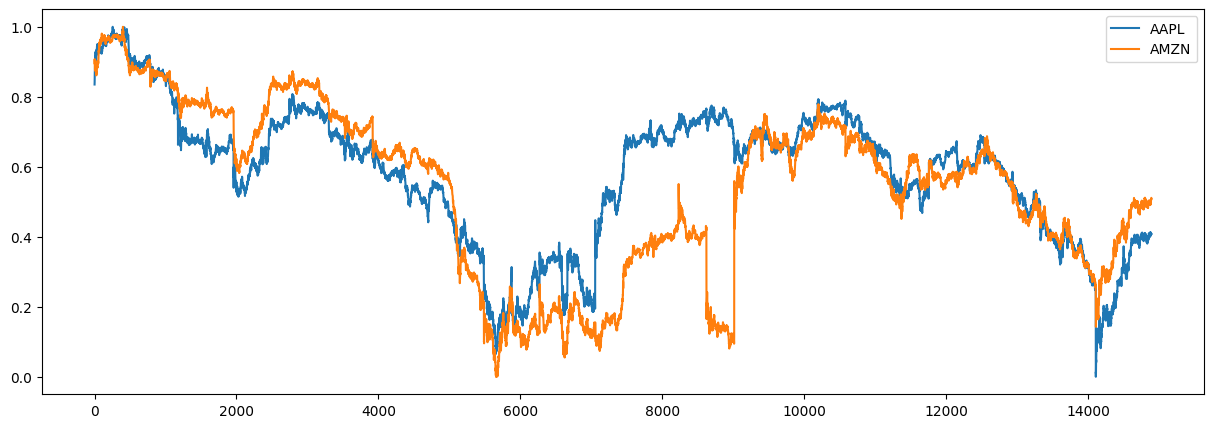

In [92]:
# plotting AAPL and AMZN stocks to see their correlation
plt.figure(figsize=(15,5))   
plt.plot(aapl_scaled_data[3], label = 'AAPL')
plt.plot(amzn_scaled_data[3], label = 'AMZN')
plt.legend()
plt.show()


It is clear that AAPL and AMZN are very closely related from the above figure

In [116]:
# Hyperparameter initialization
input_dim = 4   # open and close of two stocks
hidden_dim = 20
num_layers = 2 
output_dim = 1
batch_size = 64
learning_rate = 0.03

look_back = 5
percentage_train_split = 0.8

In [117]:
# using previousle made data loader to split the data
print('amazon split')
amzn_x_train, amzn_y_train, amzn_x_test, amzn_y_test = data_loader(amzn_scaled_data, look_back, percentage_train_split)
print()
print('aaple split')
aapl_x_train, aapl_y_train, aapl_x_test, aapl_y_test = data_loader(aapl_scaled_data, look_back, percentage_train_split)

amazon split
x_train shape:  torch.Size([11913, 4, 5])
y_train shape:  torch.Size([11913, 1])
x_test shape:  torch.Size([2978, 4, 5])
y_test shape:  torch.Size([2978, 1])

aaple split
x_train shape:  torch.Size([11913, 4, 5])
y_train shape:  torch.Size([11913, 1])
x_test shape:  torch.Size([2978, 4, 5])
y_test shape:  torch.Size([2978, 1])


In [118]:
# concatenating the close and open of amzn and aapl together
concat_x_test = torch.cat((amzn_x_test[:,:,[0,3]], aapl_x_test[:,:,[0,3]]), dim = 2)
concat_x_train = torch.cat((amzn_x_train[:,:,[0,3]], aapl_x_train[:,:,[0,3]]), dim = 2)
print('shape of concat_x_test: ', concat_x_test.shape)
print('shape of concat_x_train: ', concat_x_train.shape)

shape of concat_x_test:  torch.Size([2978, 4, 4])
shape of concat_x_train:  torch.Size([11913, 4, 4])


In [119]:
import torch.optim as optim

model = My_LSTM_Model(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)

loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train model same as used in the previous part
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  
for t in range(num_epochs):
    
    # Forward pass
    y_train_pred = model(concat_x_train)

    loss = loss_fn(y_train_pred, aapl_y_train)
    if (t+1) % 10 == 0 and t !=0:    # printing the MSE
        print("Epoch ", t+1, "MSE: ", loss.item())
    hist[t] = loss.item()   

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.024258585646748543
Epoch  20 MSE:  0.010314206592738628
Epoch  30 MSE:  0.0061658574268221855
Epoch  40 MSE:  0.0027700085192918777
Epoch  50 MSE:  0.0004680949787143618
Epoch  60 MSE:  0.0005898779490962625
Epoch  70 MSE:  0.0002477362286299467
Epoch  80 MSE:  0.0002166128542739898
Epoch  90 MSE:  0.00017578367260284722
Epoch  100 MSE:  0.0001487674453528598


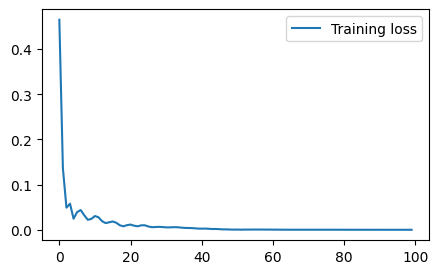

In [120]:
#plotting the training loss against epochs
plt.figure(figsize=(5,3))
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

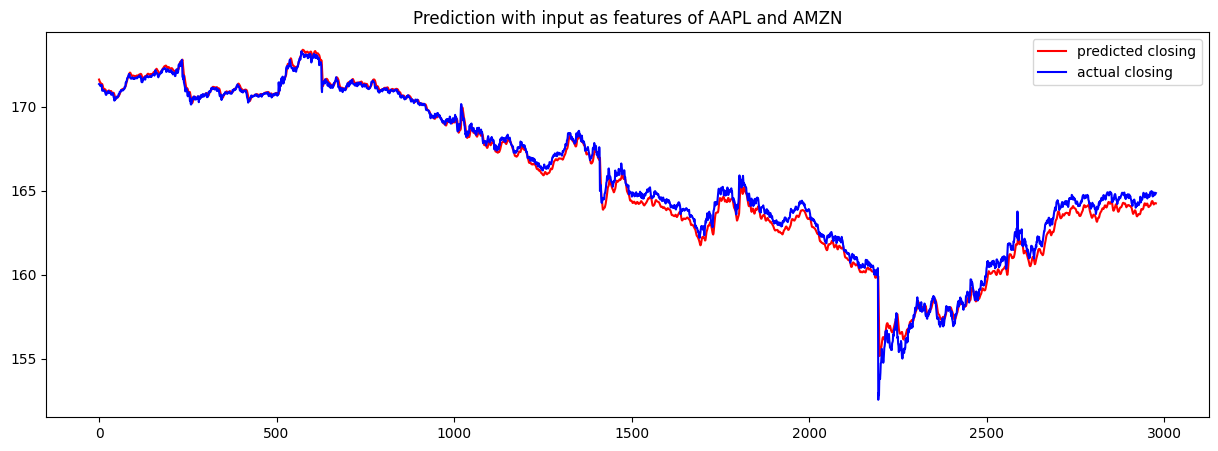

Test Score: 0.26 RMSE


In [121]:
aapl_y_test_pred = model(concat_x_test)   # making predictions

close_pred_aapl = unscale_predictions(aapl_y_test_pred,3)[:,3]   # inverse scaling
close_actual_aapl = unscale_predictions(aapl_y_test,3)[:,3]   # inverse scaling

plt.figure(figsize=(15,5))
plt.plot(close_pred_aapl, color = 'red', label ='predicted closing')
plt.plot(close_actual_aapl, color = 'blue', label ='actual closing')
plt.title('Prediction with input as features of AAPL and AMZN')
plt.legend()
plt.show()

# calculate root mean squared error 
testScore = np.mean(np.square(close_pred - close_actual))
print('Test Score: %.2f RMSE' % (testScore))

## Inference
1. Integration of various other stocks seems to improve the performance
2. This might be because the model looks at a bigger picture rather than just concentration on a single stock thus some what     
   integrating movement of the market.
3. This seem to work only when the two stocks are correlated. A stock of an agriculture company and a stock of an IT company   
   might not be show much correlation in a oeriod of few weeks

In [108]:
# adding time as an input by
# Create a time tensor of shape (look_back-1, 1)
time = np.arange(1, look_back).reshape(-1, 1)
time = torch.tensor(time)
expanded_time1 = time.expand(concat_x_test.shape[0], -1, 1)    # Expand the time tensor to match the shape of concat_x_test
expanded_time2 = time.expand(concat_x_train.shape[0], -1, 1)    # Expand the time tensor to match the shape of concat_x_train

# Concatenate along the third dimension (dim=2) to add the time dimension
concat_x_test_with_time = torch.cat((concat_x_test, expanded_time1), dim=2)
concat_x_train_with_time = torch.cat((concat_x_train, expanded_time2), dim=2)

print('shape of new x_test: ',concat_x_test_with_time.shape)
print('shape of new x_train: ',concat_x_train_with_time.shape)


shape of new x_test:  torch.Size([2978, 4, 5])
shape of new x_train:  torch.Size([11913, 4, 5])


In [123]:
import torch.optim as optim

# this time we have 5 inputs i.e open and high of two stocks along with time as well
model = My_LSTM_Model(input_dim=5, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)

loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train model same as used in the previous part
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  
for t in range(num_epochs):
    
    # Forward pass
    y_train_pred = model(concat_x_train_with_time)

    loss = loss_fn(y_train_pred, aapl_y_train)
    if (t+1) % 10 == 0 and t !=0:    # printing the MSE
        print("Epoch ", t+1, "MSE: ", loss.item())
    hist[t] = loss.item()   

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.030216561630368233
Epoch  20 MSE:  0.0217547956854105
Epoch  30 MSE:  0.008665037341415882
Epoch  40 MSE:  0.0048611960373818874
Epoch  50 MSE:  0.0010103584500029683
Epoch  60 MSE:  0.0006034939433448017
Epoch  70 MSE:  0.00016722027794457972
Epoch  80 MSE:  0.0001539323420729488
Epoch  90 MSE:  0.0001186509762192145
Epoch  100 MSE:  0.00010961380758089945


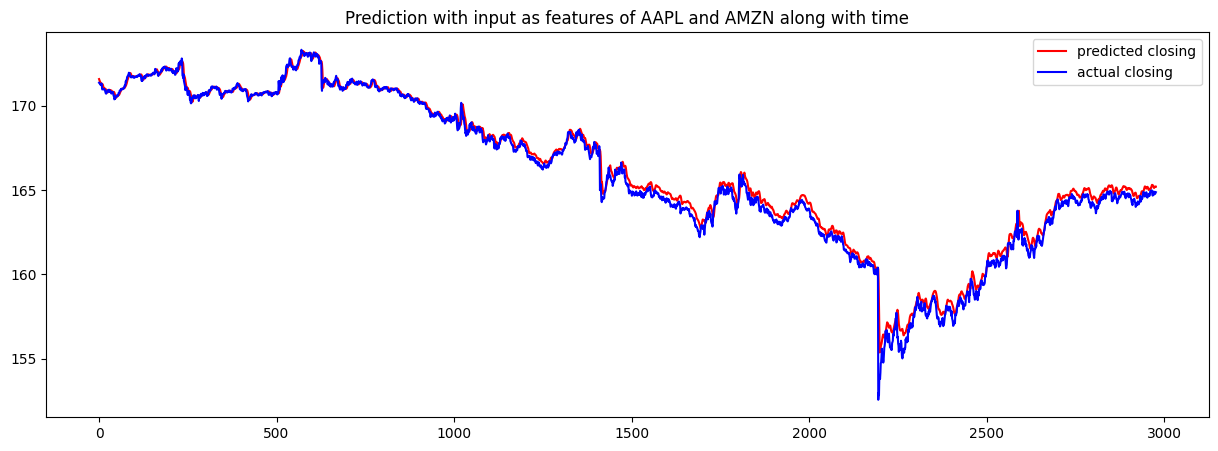

Test Score: 0.26 RMSE


In [124]:
aapl_y_test_pred_with_time = model(concat_x_test_with_time)   # making predictions

close_pred_aapl_time = unscale_predictions(aapl_y_test_pred_with_time,3)[:,3]   # inverse scaling
close_actual_aapl_time = unscale_predictions(aapl_y_test,3)[:,3]   # inverse scaling

plt.figure(figsize=(15,5))
plt.plot(close_pred_aapl_time, color = 'red', label ='predicted closing')
plt.plot(close_actual_aapl_time, color = 'blue', label ='actual closing')
plt.title('Prediction with input as features of AAPL and AMZN along with time')
plt.legend()
plt.show()

# calculate root mean squared error 
testScore = np.mean(np.square(close_pred - close_actual))
print('Test Score: %.2f RMSE' % (testScore))

## Inference
1. Including time as an input improves the result even further especially far away from the training set
2. It is also able to handle dips now pretty efficiently now

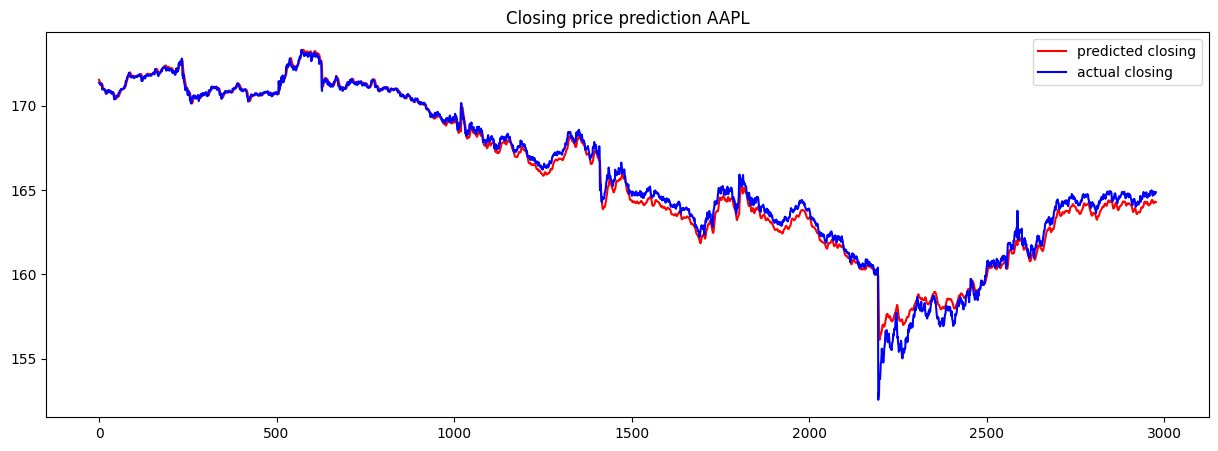

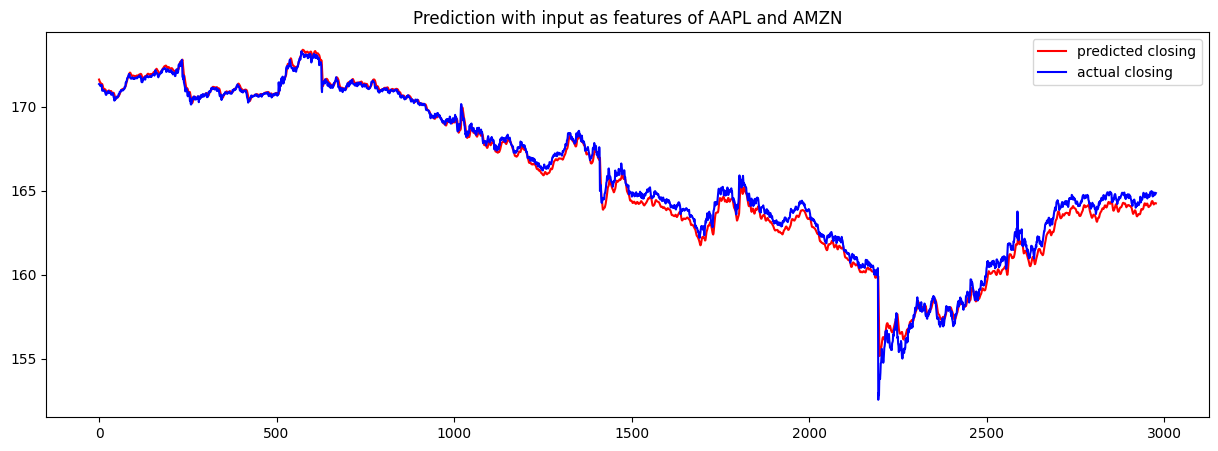

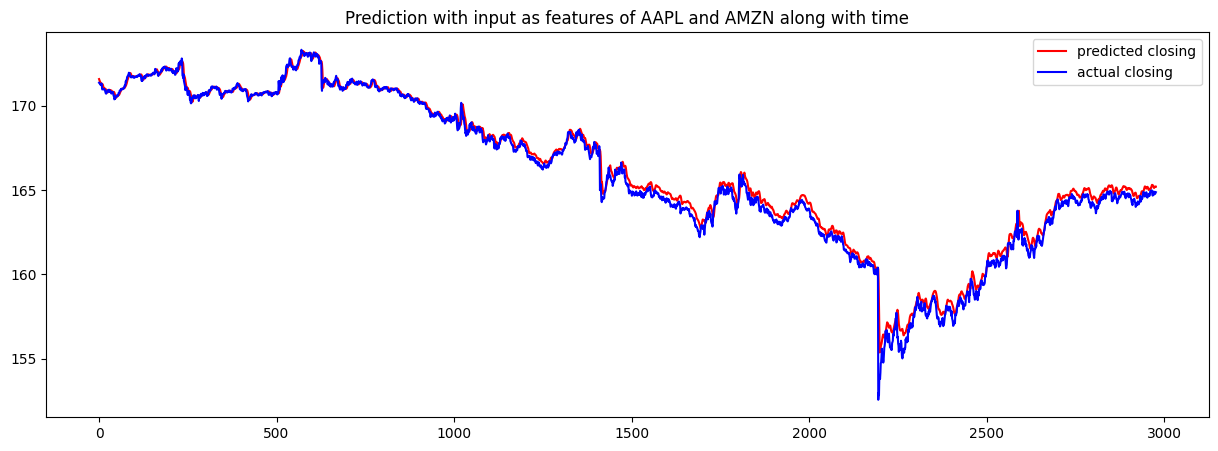

In [125]:
# plotting all the plots together for better comparision
plt.figure(figsize=(15,5))
plt.plot(close_pred, color = 'red', label ='predicted closing')
plt.plot(close_actual, color = 'blue', label ='actual closing')
plt.title('Closing price prediction AAPL')
plt.legend()
plt.show()


plt.figure(figsize=(15,5))
plt.plot(close_pred_aapl, color = 'red', label ='predicted closing')
plt.plot(close_actual_aapl, color = 'blue', label ='actual closing')
plt.title('Prediction with input as features of AAPL and AMZN')
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(close_pred_aapl_time, color = 'red', label ='predicted closing')
plt.plot(close_actual_aapl_time, color = 'blue', label ='actual closing')
plt.title('Prediction with input as features of AAPL and AMZN along with time')
plt.legend()
plt.show()


### Starter code links
1. https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm
2. https://www.kaggle.com/code/arezalo/lstm-stock-price-predition-by-pytorch
3. https://pytorch.org/tutorials/